# Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
plt.style.use('seaborn')

np.set_printoptions(precision=4)

# Read and filter data

In [3]:
data = pd.read_csv('./data_f1/data_filtered.csv')

Crear datos a partir de la inferencia de otros datos para el conductor

In [4]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

Crear datos a partir de la inferencia de otros datos para el constructor

In [5]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliability = 1-constructor_dnf_ratio
constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [45]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])
#removing retired drivers and constructors
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Max Verstappen', 'Sergio Pérez', 'Fernando Alonso', 'Lewis Hamilton',
                  'George Russell', 'Carlos Sainz', 'Charles Leclerc', 'Lance Stroll',
                  'Esteban Ocon', 'Pierre Gasly', 'Lando Norris', 'Nico Hülkenberg', 
                  'Oscar Piastri', 'Valtteri Bottas', 'Guanyu Zhou', 'Yuki Tsunoda', 
                  'Kevin Magnussen', 'Alexander Albon', 'Nyck de Vries', 'Logan Sargeant']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [47]:
data.head()

,raceId,year,round,circuitId,name_x,date,time_x,url_x,fp1_date,fp1_time,...,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,driver_confidence,constructor_reliability,active_driver,active_constructor
0,841,2011,1,1,Australian Grand Prix,2011-03-27,06:00:00,http://en.wikipedia.org/wiki/2011_Australian_G...,\N,\N,...,Nick Heidfeld,12374,0,0,0,1,0.800000,0.546693,0,1
1,338,2010,2,1,Australian Grand Prix,2010-03-28,06:00:00,http://en.wikipedia.org/wiki/2010_Australian_G...,\N,\N,...,Robert Kubica,9242,0,0,0,0,0.976190,0.546693,0,1
2,969,2017,1,1,Australian Grand Prix,2017-03-26,05:00:00,http://en.wikipedia.org/wiki/2017_Australian_G...,\N,\N,...,Nico Hülkenberg,10812,0,0,0,1,0.901639,0.546693,1,1
3,989,2018,1,1,Australian Grand Prix,2018-03-25,05:10:00,http://en.wikipedia.org/wiki/2018_Australian_G...,\N,\N,...,Nico Hülkenberg,11176,0,0,0,0,0.901639,0.546693,1,1
4,1010,2019,1,1,Australian Grand Prix,2019-03-17,05:10:00,http://en.wikipedia.org/wiki/2019_Australian_G...,\N,\N,...,Nico Hülkenberg,11533,0,0,0,1,0.901639,0.546693,1,1


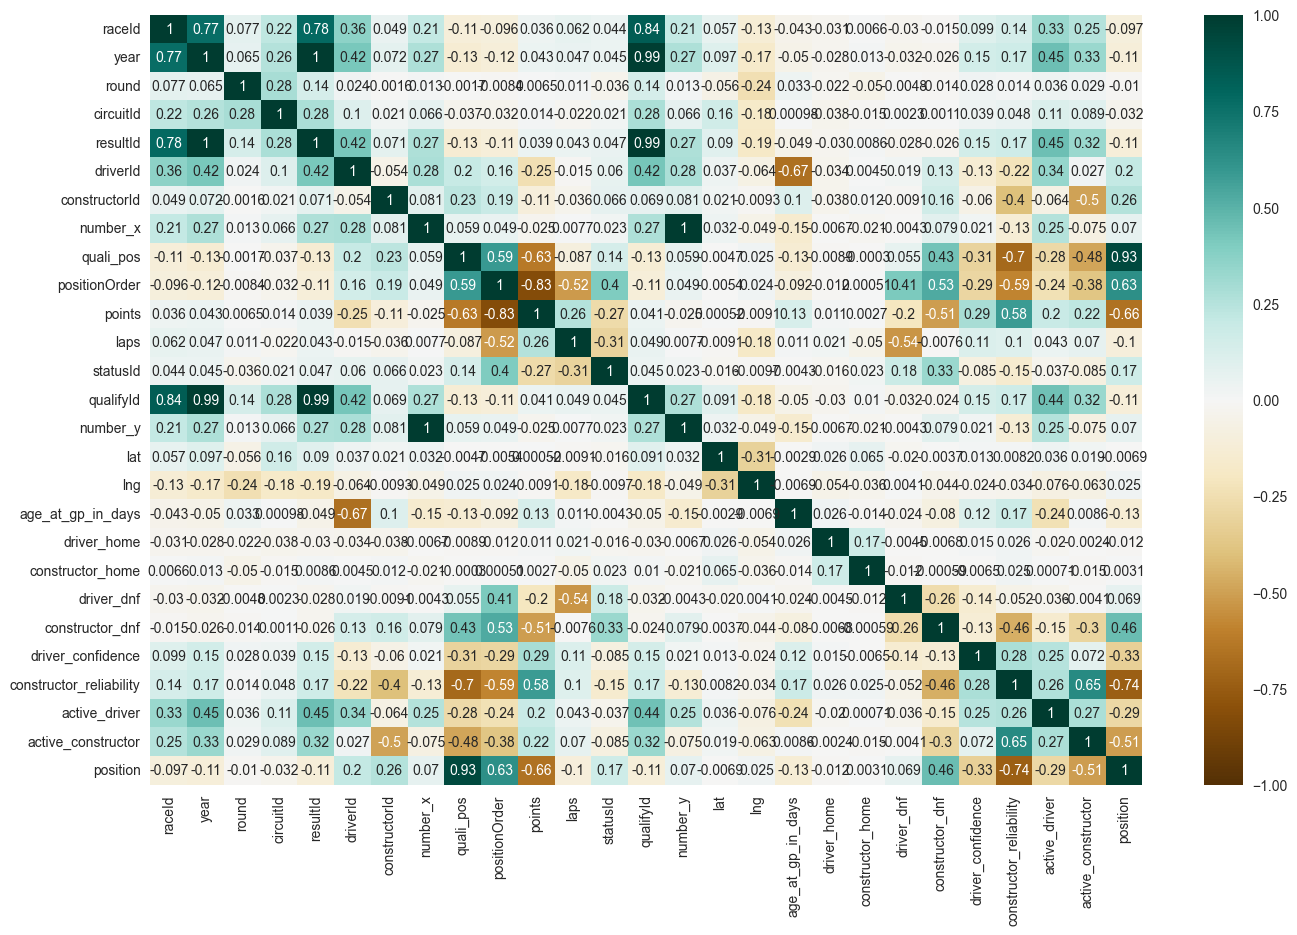

In [48]:
data2 = data[['raceId', 'year', 'round', 'circuitId', 'resultId', 'driverId', 'constructorId', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'statusId', 'qualifyId', 'number_y', 'lat', 'lng', 'age_at_gp_in_days', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver', 'active_constructor', 'position']]
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(data2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [49]:
dataFeat = data[['age_at_gp_in_days','GP_name', 'constructor','driver', 'year', 'round', 'number_x', 'quali_pos', 'positionOrder', 'points', 'laps', 'number_y', 'lat', 'lng', 'driver_home', 'constructor_home', 'driver_dnf', 'constructor_dnf', 'driver_confidence', 'constructor_reliability', 'active_driver', 'active_constructor', 'position']]